Found 3001 images belonging to 8 classes.
Found 743 images belonging to 8 classes.


C:\Users\ghwns\anaconda3\envs\ml_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\ghwns\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.1938 - loss: 2.2929 - val_accuracy: 0.3311 - val_loss: 1.9459 - learning_rate: 1.0000e-04
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.3779 - loss: 1.6507 - val_accuracy: 0.3742 - val_loss: 1.8538 - learning_rate: 1.0000e-04
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.4387 - loss: 1.5013 - val_accuracy: 0.4024 - val_loss: 1.8586 - learning_rate: 1.0000e-04
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.4617 - loss: 1.4083 - val_accuracy: 0.4226 - val_loss: 1.7858 - learning_rate: 1.0000e-04
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.4772 - loss: 1.3840 - val_accuracy: 0.4347 - val_loss: 1.6899 - learning_rate: 1.0000e-04
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.5018 - loss: 1.3125 - val_accuracy: 0.4374 - val_loss: 1.6686 - learning_rate: 1.0000e-04
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.5414 

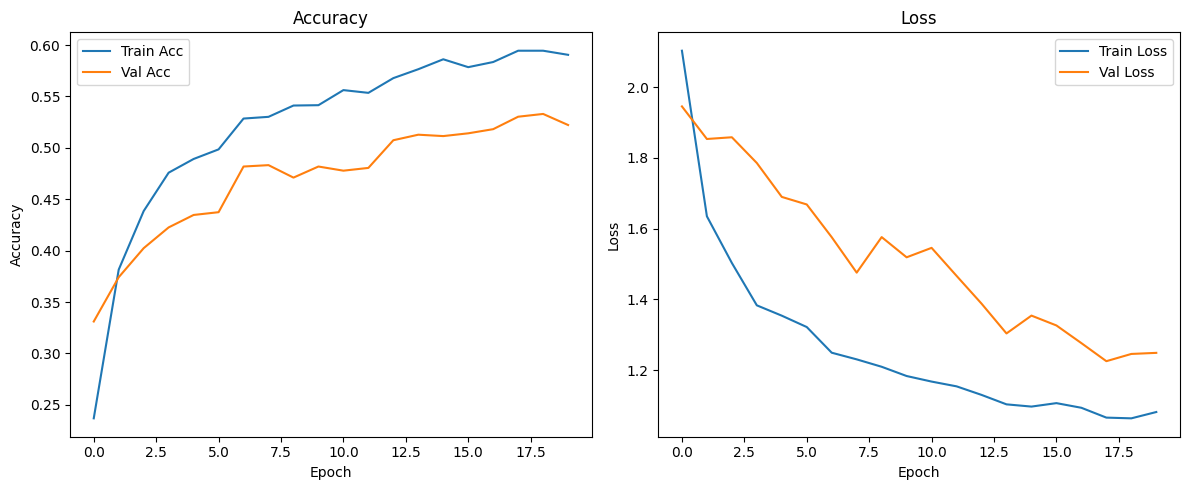

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# 📂 Paths & Params
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
data_dir = r"C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\images"
save_path = r"C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\figures"

# ✅ Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    channel_shift_range=30.0
)

# ✅ Data Generator
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    color_mode='rgb'
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    color_mode='rgb'
)

# ✅ Class Weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights = dict(enumerate(class_weights))

# ✅ Model Setup
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ✅ Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[lr_scheduler, early_stop],
    class_weight=class_weights
)

# ✅ Best Val Acc
best_epoch = max(enumerate(history.history['val_accuracy']), key=lambda x: x[1])
print(f"\n🏆 Best Val Acc: {best_epoch[1]:.4f} at Epoch {best_epoch[0] + 1}")

# ✅ Visualization & Save
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

# ✅ Save to path
os.makedirs(save_path, exist_ok=True)
plt.savefig(os.path.join(save_path, "20250604_mobilenetv2_reset.png"))
plt.show()